In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
import cPickle as pickle
import nolearn
import nolearn.lasagne
import lasagne.layers
from ml_helpers import minibatch_generators as mbg

base = '/media/michael/Seagate/engage/urban8k/'

Using gpu device 0: GeForce GTX 770 (CNMeM is disabled, cuDNN 5004)
/home/michael/anaconda/lib/python2.7/site-packages/Theano-0.9.0.dev1-py2.7.egg/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [28]:
# loading data
folds = {}
for fold in range(1, 11):
    loadpath = base + 'specs/fold%d.pkl' % fold
    folds[fold] = pickle.load(open(loadpath))

In [29]:
# data splits
splits = {'train': [1, 2, 3, 4, 5, 6, 7, 8, 10], 'val': [9], 'test': [10]}

data = {'train': {'X': [], 'y': []}, 
        'val': {'X': [], 'y': []}, 
        'test': {'X': [], 'y': []}}

for key, val in splits.iteritems():
    for fold_id in val:
        data[key]['X'] += folds[fold_id]['X']
        data[key]['y'] += list(folds[fold_id]['classID'])

    data[key]['X'] = mbg.form_correct_shape_array(data[key]['X'])
    med = np.mean(data[key]['X'].reshape(data[key]['X'].shape[0], -1), 1)
    med[med==0] = 0.1
    data[key]['X'] = data[key]['X'] / med[:, None, None, None]
    data[key]['X'] = data[key]['X'].astype(np.float32)
    data[key]['y'] = np.array(data[key]['y']).astype(np.int32)

In [11]:
del folds

0.0
1


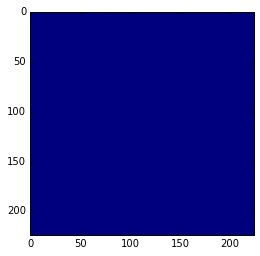

In [12]:
#print np.isnan(data['train']['X']).sum()
med = np.max(data['train']['X'].reshape(data['train']['X'].shape[0], -1), 1)
print np.min(med)
tmp = data['train']['X'] / med[:, None, None, None]
print (med==0).sum()
np.argmin(med)
plt.imshow(data['train']['X'][3883][0])

In [24]:
from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.nonlinearities import softmax

net = {}
net['input'] = InputLayer((None, 1, 224, 224))
net['conv1_1'] = ConvLayer(net['aa'], 32, 3, pad=1, flip_filters=False)
net['conv1_2'] = ConvLayer(net['conv1_1'], 32, 3, pad=1, flip_filters=False)
net['pool1'] = PoolLayer(net['conv1_2'], 2)
net['conv2_1'] = ConvLayer(net['pool1'], 32, 3, pad=1, flip_filters=False)
net['conv2_2'] = ConvLayer(net['conv2_1'], 32, 3, pad=1, flip_filters=False)
net['pool2'] = PoolLayer(net['conv2_2'], 4)
net['conv3_1'] = ConvLayer(net['pool2'], 32, 3, pad=1, flip_filters=False)
net['conv3_2'] = ConvLayer(net['conv3_1'], 32, 3, pad=1, flip_filters=False)
net['fc6'] = DenseLayer(net['conv3_2'], num_units=256)
net['fc6'] = DropoutLayer(net['fc6'], p=0.5)
net['fc7'] = DenseLayer(net['fc6'], num_units=256)
net['fc7'] = DropoutLayer(net['fc7'], p=0.5)
net['fc8'] = DenseLayer(net['fc7'], num_units=10, nonlinearity=None)
net['prob'] = NonlinearityLayer(net['fc8'], softmax)

In [33]:
# setting up network
class MyTrainSplit(nolearn.lasagne.TrainSplit):
    # custom data split
    def __call__(self, data, Yb, net):
        return data['train']['X'], data['val']['X'], data['train']['y'], data['val']['y']

def augment(X):
    for idx in xrange(X.shape[0]):
        mult = (1.0 + np.random.randn() * 0.1)
        add = np.random.randn() * 0.01
        X[idx] *= mult
        X[idx] += add
        if np.random.rand() > 0.9:
            shift = np.random.randint(0, 224)
            X[idx, 0] = np.roll(X[idx, 0], shift, 1)
        
    return X
    
class MyBatch(nolearn.lasagne.BatchIterator):
    def transform(self, Xb, yb):
        return augment(Xb), yb

    def __iter__(self):
        bs = self.batch_size
        for batch_idxs in mbg.minibatch_idx_iterator(
                self.y, bs, randomise=0, balanced=0):

            Xb = self.X[batch_idxs]
            yb = self.y[batch_idxs]
            yield self.transform(Xb, yb)
    

network = nolearn.lasagne.NeuralNet(
    layers=net['prob'],
    max_epochs=500,
    update=lasagne.updates.nesterov_momentum,
    update_learning_rate=0.0005,
    update_momentum=0.975,
    verbose=1,
    train_split=MyTrainSplit(None),
    batch_iterator_train=MyBatch(batch_size=64)
)

In [ ]:
# training
network.fit(data, None)

# Neural Network with 1720810 learnable parameters

## Layer information

  #    name  size
---  ------  ----------
  0          1x224x224
  1          1x112x112
  2          32x112x112
  3          32x112x112
  4          32x56x56
  5          32x56x56
  6          32x56x56
  7          32x14x14
  8          32x14x14
  9          32x14x14
 10          256
 11          256
 12          256
 13          256
 14          10
 15          10

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       0.19038       1.84895      0.10297      0.74070  22.45s
      2       0.19329       1.72549      0.11202      0.75818  22.38s
      3       0.20138       1.81688      0.11084      0.75707  22.54s
      4       0.16368       1.79282      0.09130      0.76228  22.35s
      5       0.16258       1.71790      0.09464      0.76935  22.26s
      6       0.17231       1.97334      0.08732      0.75558  22.21s


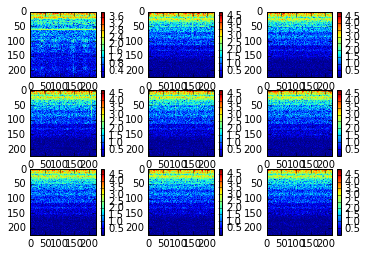

In [31]:
idxs = data['train']['y'] == 0
sx = data['train']['X'][idxs]
for ind, x in enumerate(sx[:9]):
    plt.subplot(3, 3, ind+1)
    plt.imshow(x[0])
    plt.colorbar()

In [32]:
network.save_params_to('params')